In [1]:
import numpy as np
from collections import Counter
import pickle
from sklearn.metrics import accuracy_score

# Function to load the dataset.csv dataset
def load_dataset(file_path):
    # Load the CSV file using numpy
    data = np.loadtxt(file_path, delimiter=',', skiprows=1)  # Skip the header row

    # The first column is the label, the rest are pixel values
    X = data[:, 1:]  # All columns except the first (pixel values)
    y = data[:, 0]   # The first column is the label

    # Normalize pixel values to the range [0, 1]
    X = X / 255.0

    return X, y

# Decision Tree Implementation (using ID3 algorithm)
class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        unique_classes = np.unique(y)

        # Stopping conditions
        if len(unique_classes) == 1:
            return unique_classes[0]
        if num_samples < self.min_samples_split or (self.max_depth is not None and depth >= self.max_depth):
            return Counter(y).most_common(1)[0][0]

        # Best split
        best_split = self._best_split(X, y, num_features)
        if best_split is None:
            return Counter(y).most_common(1)[0][0]

        left_indices = X[:, best_split['feature']] <= best_split['threshold']
        right_indices = ~left_indices

        left_tree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_tree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return {'feature': best_split['feature'], 'threshold': best_split['threshold'], 'left': left_tree, 'right': right_tree}

    def _best_split(self, X, y, num_features):
        best_info_gain = -float('inf')
        best_split = {}

        for feature in range(num_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_indices = X[:, feature] <= threshold
                right_indices = ~left_indices
                if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
                    continue

                info_gain = self._information_gain(y, y[left_indices], y[right_indices])
                if info_gain > best_info_gain:
                    best_info_gain = info_gain
                    best_split = {'feature': feature, 'threshold': threshold}

        return best_split

    def _information_gain(self, parent, left_child, right_child):
        p_entropy = self._entropy(parent)
        left_entropy = self._entropy(left_child)
        right_entropy = self._entropy(right_child)

        weighted_avg = (len(left_child) / len(parent)) * left_entropy + (len(right_child) / len(parent)) * right_entropy
        return p_entropy - weighted_avg

    def _entropy(self, y):
        class_counts = Counter(y)
        entropy = 0
        for count in class_counts.values():
            prob = count / len(y)
            entropy -= prob * np.log2(prob)
        return entropy

    def predict(self, X):
        return np.array([self._predict_one(x, self.tree) for x in X])

    def _predict_one(self, x, tree):
        if isinstance(tree, dict):
            if x[tree['feature']] <= tree['threshold']:
                return self._predict_one(x, tree['left'])
            else:
                return self._predict_one(x, tree['right'])
        else:
            return tree

# Random Forest Implementation
class RandomForest:
    def __init__(self, n_trees=100, max_depth=None, min_samples_split=2):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.trees = []

    def fit(self, X, y):
        for _ in range(self.n_trees):
            # Bootstrap sampling
            indices = np.random.choice(len(X), len(X), replace=True)
            X_bootstrap = X[indices]
            y_bootstrap = y[indices]

            tree = DecisionTree(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            tree.fit(X_bootstrap, y_bootstrap)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        # Majority voting
        majority_votes = [Counter(tree_preds[:, i]).most_common(1)[0][0] for i in range(X.shape[0])]
        return np.array(majority_votes)

# Function to calculate accuracy
def calculate_accuracy(predictions, true_labels):
    correct = np.sum(predictions == true_labels)
    accuracy = correct / len(true_labels) * 100
    return accuracy

# Split dataset into training and validation (80% training, 20% validation)
def train_test_split_custom(X, y, test_size=0.3):
    num_samples = len(X)
    num_test = int(num_samples * test_size)
    indices = np.random.permutation(num_samples)

    # Test set
    X_test = X[indices[:num_test]]
    y_test = y[indices[:num_test]]

    # Training set
    X_train = X[indices[num_test:]]
    y_train = y[indices[num_test:]]

    return X_train, X_test, y_train, y_test

# Example usage
if __name__ == '__main__':
    # Load dataset
    file_path = 'dataset.csv'  # Replace with your dataset file path
    X, y = load_dataset(file_path)

    # Split dataset into training and testing (80/20 split)
    X_train, X_test, y_train, y_test = train_test_split_custom(X.reshape(-1, 28*28), y)  # Flatten images for ML model

    # Train Random Forest
    rf = RandomForest(n_trees=10, max_depth=5, min_samples_split=10)
    rf.fit(X_train, y_train)

    # Predict on training set
    train_preds = rf.predict(X_train)
    train_accuracy = calculate_accuracy(train_preds, y_train)

    # Predict on test set
    test_preds = rf.predict(X_test)
    test_accuracy = calculate_accuracy(test_preds, y_test)

    # Print accuracies
    print(f"Training Accuracy: {train_accuracy:.2f}%")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    # Save the trained Random Forest model using pickle
    with open("random_forest_model.pkl", "wb") as model_file:
        pickle.dump(rf, model_file)
    print("Model saved to 'random_forest_model.pkl'")



Training Accuracy: 90.14%
Test Accuracy: 78.67%
Model saved to 'random_forest_model.pkl'


Accuracy for digit 0: 86.27%
Accuracy for digit 1: 82.22%
Accuracy for digit 2: 93.48%
Accuracy for digit 3: 88.89%
Accuracy for digit 4: 89.36%
Accuracy for digit 5: 69.81%
Accuracy for digit 6: 98.25%
Accuracy for digit 7: 92.00%
Accuracy for digit 8: 87.50%
Accuracy for digit 9: 86.00%


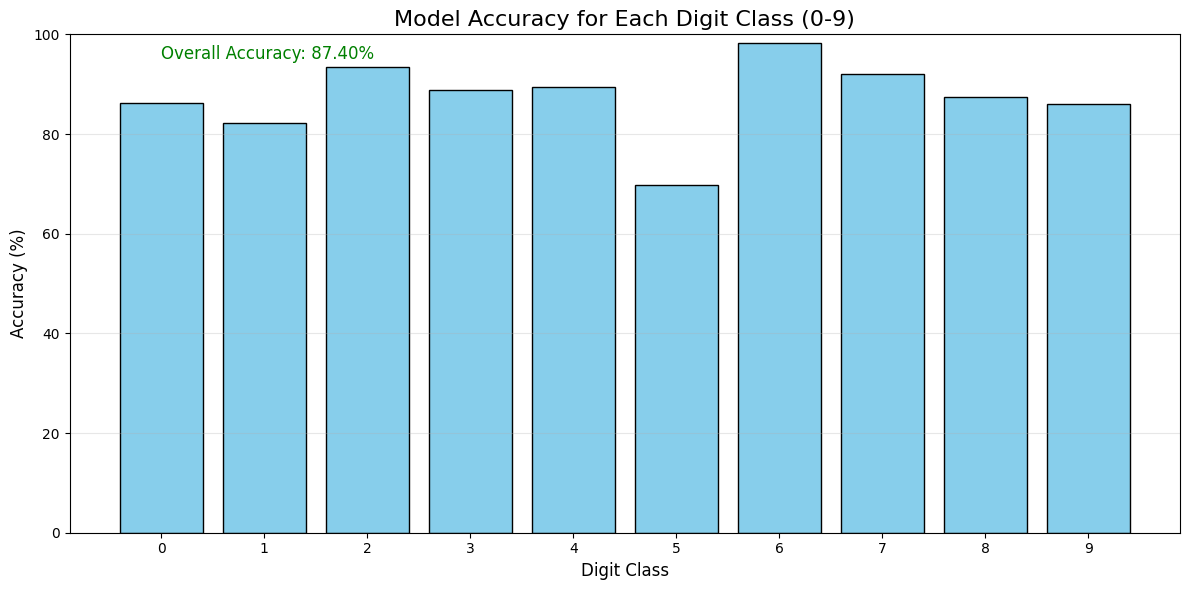

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Function to load the dataset
def load_dataset(file_path):
    # Load the CSV file using numpy
    data = np.loadtxt(file_path, delimiter=',', skiprows=1)  # Skip the header row

    # The first column is the label, the rest are pixel values
    X = data[:, 1:]  # All columns except the first (pixel values)
    y = data[:, 0]   # The first column is the label

    # Normalize pixel values to the range [0, 1]
    X = X / 255.0

    return X, y

# Example usage for loading and predicting with the saved model
if __name__ == '__main__':
    # Load the model from the pickle file
    with open("random_forest_model.pkl", "rb") as model_file:
        rf = pickle.load(model_file)

    # Load dataset
    file_path = 'dataset.csv'  # Replace with your dataset file path
    X, y = load_dataset(file_path)

    # Flatten the dataset for prediction (if needed for your model)
    X_flat = X.reshape(-1, 28 * 28)

    # Select 500 random samples
    num_samples = 500
    random_indices = np.random.choice(X_flat.shape[0], num_samples, replace=False)

    # Get the selected random samples and their corresponding labels
    X_random = X_flat[random_indices]
    y_random = y[random_indices]

    # Predict using the RandomForest model
    predictions = rf.predict(X_random)

    # Calculate accuracy
    overall_accuracy = accuracy_score(y_random, predictions)

    # Calculate accuracy for each digit class (0-9)
    digit_accuracies = []
    for digit in range(10):
        digit_indices = y_random == digit
        if np.sum(digit_indices) > 0:  # Avoid division by zero for classes not in the sample
            digit_accuracy = accuracy_score(y_random[digit_indices], predictions[digit_indices])
            digit_accuracies.append(digit_accuracy * 100)
        else:
            digit_accuracies.append(0)  # If no samples for the digit, set accuracy to 0

    # Print accuracy for each digit
    for digit, accuracy in enumerate(digit_accuracies):
        print(f"Accuracy for digit {digit}: {accuracy:.2f}%")

    # Plot the accuracy for each digit
    plt.figure(figsize=(12, 6))
    plt.bar(range(10), digit_accuracies, color='skyblue', edgecolor='black')
    plt.title("Model Accuracy for Each Digit Class (0-9)", fontsize=16)
    plt.xlabel("Digit Class", fontsize=12)
    plt.ylabel("Accuracy (%)", fontsize=12)
    plt.xticks(range(10), [str(d) for d in range(10)])
    plt.ylim(0, 100)
    plt.grid(axis='y', alpha=0.3)

    # Display overall accuracy on the plot
    plt.text(0, 95, f"Overall Accuracy: {overall_accuracy * 100:.2f}%", fontsize=12, color='green')

    plt.tight_layout()
    plt.show()
